In [2]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from tqdm import tqdm
from scipy import signal
import json

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [3]:
filtered_df = pd.read_parquet("complete_stock_data.parquet")

In [3]:
filtered_df.shape

(14492115, 10)

In [4]:
filtered_df.columns

Index(['date', 'symbol', 'open', 'high', 'low', 'close', 'volume', 'dividends',
       'stock_splits', 'last_updated'],
      dtype='object')

In [5]:
#distribution of actual number of trading days per year in the dataset
pd.Series(pd.to_datetime(filtered_df["date"].unique())).dt.year.value_counts().describe()

count     94.000000
mean     251.617021
std        1.296035
min      248.000000
25%      251.000000
50%      252.000000
75%      253.000000
max      254.000000
Name: count, dtype: float64

In [6]:
trading_days_estimate = pd.Series(pd.to_datetime(filtered_df["date"].unique())).dt.year.value_counts().agg(["mean","std"])

In [7]:
print(254**0.5)
print(248**0.5)
print(trading_days_estimate.loc["mean"]**0.5)

15.937377450509228
15.748015748023622
15.862440583863371


In [8]:
print((254**0.5-trading_days_estimate.loc["mean"]**0.5)/trading_days_estimate.loc["mean"]**0.5)
print((-248**0.5+trading_days_estimate.loc["mean"]**0.5)/trading_days_estimate.loc["mean"]**0.5)

0.0047241700449355
0.00721357065041755


In [ ]:
def calculate_financial_metrics(df):
    # Sort data
    print("Sorting data...")
    df = df.sort_values(['symbol', 'date'])
    
    # Calculate daily returns
    print("Calculating daily returns...")
    df['daily_return'] = df.groupby('symbol')['close'].pct_change()
    
    # Calculate various metrics by symbol
    metrics = []
    symbols = df['symbol'].unique()
    
    print("Processing symbols...")
    for symbol in tqdm(symbols, desc="Calculating metrics"):
        symbol_data = df[df['symbol'] == symbol]
        
        # Basic metrics
        volatility = symbol_data['daily_return'].std() * (252 ** 0.5)  # Annualized volatility
        avg_volume = symbol_data['volume'].mean()
        
        # Calculate moving averages
        symbol_data['MA50'] = symbol_data['close'].rolling(window=50).mean()
        symbol_data['MA200'] = symbol_data['close'].rolling(window=200).mean()
        
        # Calculate RSI
        delta = symbol_data['close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        
        metrics.append({
            'symbol': symbol,
            'volatility': volatility,
            'avg_daily_volume': avg_volume,
            'avg_daily_return': symbol_data['daily_return'].mean(),
            'sharpe_ratio': symbol_data['daily_return'].mean() / symbol_data['daily_return'].std() * (252 ** 0.5),
            'last_rsi': rsi.iloc[-1] if len(rsi) > 0 else None,
            'current_price': symbol_data['close'].iloc[-1],
            'price_change_ytd': (symbol_data['close'].iloc[-1] / symbol_data['close'].iloc[0] - 1) * 100
        })
        
        # Free up memory
        del symbol_data
    
    return pd.DataFrame(metrics)

In [4]:
financial_analysis = calculate_financial_metrics(filtered_df)

Sorting data...
Calculating daily returns...


/tmp/ipykernel_156346/1436326950.py:11: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['daily_return'] = df.groupby('symbol')['close'].pct_change()


Processing symbols...


Calculating metrics:   0%|          | 0/3676 [00:00<?, ?it/s]/tmp/ipykernel_156346/1436326950.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  symbol_data['MA50'] = symbol_data['close'].rolling(window=50).mean()
/tmp/ipykernel_156346/1436326950.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  symbol_data['MA200'] = symbol_data['close'].rolling(window=200).mean()
Calculating metrics:   0%|          | 1/3676 [00:01<1:21:39,  1.33s/it]/tmp/ipykernel_156346/1436326950.py:26: SettingWithCopyWarning: 
A v

In [5]:
financial_analysis.shape

(3676, 8)

In [6]:
financial_analysis.to_parquet("financial_metrics.parquet")

In [7]:
financial_analysis.sort_values(by=["avg_daily_return","volatility"],ascending=[False])

,symbol,volatility,avg_daily_volume,avg_daily_return,sharpe_ratio,last_rsi,current_price,price_change_ytd
0,A,0.407381,3.306416e+06,0.000505,0.312471,22.472961,134.360107,209.136528
1,AACG,2.572110,1.899165e+05,0.003471,0.340056,46.487605,0.812800,92.810532
2,AADI,0.911883,1.660735e+05,0.000332,0.091842,62.903221,3.030000,-89.849246
3,AAL,0.655060,1.628552e+07,0.000688,0.264735,50.086975,17.495001,-50.447042
4,AAME,0.824862,2.367316e+04,0.001185,0.362118,51.785714,1.550000,-67.970715
...,...,...,...,...,...,...,...,...
3671,ZYXI,1.137102,1.388790e+05,0.003327,0.737427,40.647231,8.002900,5353.316735
3672,^DJI,0.174298,1.983531e+08,0.000373,0.539207,26.108583,42573.730469,1242.003902
3673,^GSPC,0.193779,9.468168e+08,0.000319,0.414781,38.535747,5906.939941,33159.796539
3674,^IXIC,0.201920,1.291367e+09,0.000466,0.581259,44.940781,19399.708984,16969.695314


In [8]:
financial_analysis.to_csv("financial_metrics.csv",index=False)

In [3]:
def analyze_frequency_components(returns, fs=1):
    """
    Analyze the frequency components of a return series using Welch's method
    
    Parameters:
    returns: array-like, return series
    fs: sampling frequency (1 for daily data)
    
    Returns:
    frequencies: array of frequencies
    psd: power spectral density
    """
    # Remove NaN values
    returns = returns.dropna()
    
    # Use Welch's method to estimate power spectral density
    # Using overlapping windows to reduce noise
    frequencies, psd = signal.welch(
        returns,
        fs=fs,
        nperseg=min(256, len(returns)//4),  # Length of each segment
        noverlap=min(128, len(returns)//8),  # Overlap between segments
        detrend='constant',
        scaling='density'
    )
    
    return frequencies, psd

def identify_dominant_cycles(frequencies, psd, min_period=2):
    """
    Identify dominant cycles in the power spectrum
    
    Parameters:
    frequencies: array of frequencies
    psd: power spectral density
    min_period: minimum period to consider (in days)
    
    Returns:
    list of (period, power) tuples sorted by power
    """
    # Convert frequencies to periods
    periods = 1/frequencies
    
    # Find local maxima in the PSD
    peaks = signal.find_peaks(psd)[0]
    
    # Create list of (period, power) tuples for periods > min_period
    cycles = [(periods[i], psd[i]) for i in peaks if periods[i] > min_period]
    
    # Sort by power (descending)
    return sorted(cycles, key=lambda x: x[1], reverse=True)

def analyze_stock_timescales(df, symbol):
    """
    Analyze natural timescales present in a stock's returns
    
    Parameters:
    df: DataFrame with 'symbol', 'date', 'close' columns
    symbol: stock symbol to analyze
    
    Returns:
    dict with analysis results
    """
    # Get symbol data
    symbol_data = df[df['symbol'] == symbol].sort_values('date')
    
    # Calculate returns
    returns = symbol_data['close'].pct_change().dropna()
    
    # Get frequency components
    frequencies, psd = analyze_frequency_components(returns)
    
    # Identify dominant cycles
    cycles = identify_dominant_cycles(frequencies, psd)
    
    # Calculate total power and relative importance of each cycle
    total_power = np.sum(psd)
    
    # Get top cycles and their relative power
    top_cycles = []
    for period, power in cycles[:5]:  # Top 5 cycles
        relative_power = (power / total_power) * 100
        days = period
        if days >= 252:  # Convert to years if >= 1 year
            top_cycles.append({
                'period': f'{days/252:.1f} years',
                'relative_power': relative_power
            })
        elif days >= 21:  # Convert to months if >= 1 month
            top_cycles.append({
                'period': f'{days/21:.1f} months',
                'relative_power': relative_power
            })
        else:
            top_cycles.append({
                'period': f'{days:.1f} days',
                'relative_power': relative_power
            })
    
    return {
        'symbol': symbol,
        'frequencies': frequencies,
        'psd': psd,
        'top_cycles': top_cycles,
        'returns': returns
    }

def plot_spectral_analysis(analysis_result, title=None, window_sizes=[5, 20]):
    """
    Plot the spectral analysis results with dark theme, including smoothed versions
    
    Parameters:
    analysis_result: dict containing frequencies and psd
    title: optional title for the plot
    window_sizes: list of window sizes for different levels of smoothing
    """
    frequencies = analysis_result['frequencies']
    psd = analysis_result['psd'][1:]
    
    # Convert frequencies to periods
    periods = 1/frequencies[1:]
    
    # Set dark theme
    plt.style.use('dark_background')
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot raw PSD vs Period
    ax.semilogx(periods, psd, color='#00ff88', alpha=0.3, label='Raw')
    
    # Calculate and plot smoothed versions
    colors = ['#00ffff', '#ff00ff']  # Cyan and Magenta for smoothed lines
    
    for window_size, color in zip(window_sizes, colors):
        # Use pandas rolling average for smoothing
        import pandas as pd
        smoothed = pd.Series(psd).rolling(window=window_size, center=True).mean()
        ax.semilogx(periods, smoothed, 
                   color=color, 
                   linewidth=2, 
                   label=f'{window_size}-period smooth')
    
    # Configure grid
    ax.grid(True, linestyle='--', alpha=0.3)
    
    # Style labels
    ax.set_xlabel('Period (days)', color='white', size=10)
    ax.set_ylabel('Power Spectral Density', color='white', size=10)
    
    if title:
        ax.set_title(f'Power Spectrum - {title}', color='white', size=12)
    
    # Add vertical lines for common periods
    common_periods = {
        5: 'Weekly',
        21: 'Monthly',
        63: 'Quarterly',
        252: 'Yearly'
    }
    
    # Get the current y-limits for text placement
    y_max = ax.get_ylim()[1]
    
    for period, label in common_periods.items():
        ax.axvline(x=period, color='#ff6b6b', linestyle='--', alpha=0.4)
        ax.text(period, y_max, label, rotation=90, 
                color='#ff6b6b', alpha=0.7, 
                verticalalignment='top')
    
    # Add legend
    ax.legend(loc='upper right', framealpha=0.8)
    
    # Style tick labels
    ax.tick_params(colors='white')
    
    # Set figure background color
    fig.patch.set_facecolor('#1a1a1a')
    ax.set_facecolor('#1a1a1a')
    
    plt.title(analysis_result["symbol"])
    plt.tight_layout()
    plt.show()
    plt.close()

def analyze_market_natural_cycles(df, n_samples=None):
    """
    Analyze natural cycles across the market
    
    Parameters:
    df: DataFrame with market data
    n_samples: number of random symbols to analyze (None for all)
    
    Returns:
    DataFrame with aggregated cycle information
    """
    symbols = df['symbol'].unique()
    
    if n_samples is not None:
        symbols = np.random.choice(symbols, size=min(n_samples, len(symbols)), replace=False)
    
    all_results = []
    
    for symbol in tqdm(symbols, desc="Analyzing natural cycles"):
        try:
            result = analyze_stock_timescales(df, symbol)
            # Flatten top cycles into columns
            for i, cycle in enumerate(result['top_cycles']):
                result[f'cycle_{i+1}_period'] = cycle['period']
                result[f'cycle_{i+1}_power'] = cycle['relative_power']
            
            all_results.append(result)
        except Exception as e:
            print(f"Error analyzing {symbol}: {str(e)}")
    
    return all_results

# Example usage:
# results = analyze_market_natural_cycles(df, n_samples=100)
# 
# # Analyze a specific stock
# analysis = analyze_stock_timescales(df, 'AAPL')
# plot_spectral_analysis(analysis, 'AAPL')
#
# # Print dominant cycles
# for cycle in analysis['top_cycles']:
#     print(f"Period: {cycle['period']}, Relative Power: {cycle['relative_power']:.2f}%")

In [10]:
cycles_results = analyze_market_natural_cycles(filtered_df)

Analyzing natural cycles:   0%|          | 0/3676 [00:00<?, ?it/s]/tmp/ipykernel_156346/1759431927.py:48: RuntimeWarning: divide by zero encountered in divide
  periods = 1/frequencies
Analyzing natural cycles:   2%|▏         | 70/3676 [00:58<48:50,  1.23it/s]/tmp/ipykernel_156346/1759431927.py:74: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = symbol_data['close'].pct_change().dropna()
Analyzing natural cycles: 100%|██████████| 3676/3676 [51:56<00:00,  1.18it/s] 


In [12]:
len(cycles_results)

3676

In [6]:
def save_spectral_results(results, base_filename):
    """
    Save spectral analysis results to files.
    
    Parameters:
    results: List of dictionaries containing spectral analysis results
    base_filename: Base name for the files (without extension)
    """
    # Convert the main results to a DataFrame
    main_data = []
    for result in results:
        # Extract the basic metrics
        main_row = {
            'symbol': result['symbol'],
            'frequencies': json.dumps(result.get('frequencies', []).tolist()),
            'psd': json.dumps(result.get('psd', []).tolist())
        }
        
        # Add the top cycles
        for i, cycle in enumerate(result.get('top_cycles', [])):
            main_row[f'cycle_{i+1}_period'] = cycle.get('period')
            main_row[f'cycle_{i+1}_power'] = cycle.get('relative_power')
            
        main_data.append(main_row)
    
    # Create DataFrames
    main_df = pd.DataFrame(main_data)
    
    # Save to files
    main_df.to_parquet(f"{base_filename}.parquet")
    print(f"Results saved to {base_filename}.parquet")

def load_spectral_results(filename):
    """
    Load spectral analysis results from files.
    
    Parameters:
    filename: Path to the .parquet file (without extension)
    
    Returns:
    List of dictionaries containing the spectral analysis results
    """
    # Load the main DataFrame
    main_df = pd.read_parquet(f"{filename}.parquet")
    
    # Convert back to original format
    results = []
    for _, row in main_df.iterrows():
        result = {
            'symbol': row['symbol'],
            'frequencies': np.array(json.loads(row['frequencies'])),
            'psd': np.array(json.loads(row['psd'])),
            'top_cycles': []
        }
        
        # Reconstruct top cycles
        cycle_columns = [col for col in row.index if col.startswith('cycle_')]
        num_cycles = len(cycle_columns) // 2
        
        for i in range(num_cycles):
            if pd.notna(row[f'cycle_{i+1}_period']):
                result['top_cycles'].append({
                    'period': row[f'cycle_{i+1}_period'],
                    'relative_power': row[f'cycle_{i+1}_power']
                })
        
        results.append(result)
    
    return results

# Example usage:
"""
# Saving results
save_spectral_results(spectral_results, 'spectral_analysis_results')

# Loading results
loaded_results = load_spectral_results('spectral_analysis_results')

# Quick analysis of loaded results
def analyze_loaded_results(results):
    '''Print summary statistics of the loaded results'''
    num_symbols = len(results)
    avg_cycles = np.mean([len(r['top_cycles']) for r in results])
    
    # Find most common periods
    all_periods = []
    for r in results:
        for cycle in r['top_cycles']:
            all_periods.append(cycle['period'])
    
    period_counts = pd.Series(all_periods).value_counts().head()
    
    print(f"Number of symbols analyzed: {num_symbols}")
    print(f"Average number of cycles per symbol: {avg_cycles:.2f}")
    print("\nMost common periods (days):")
    for period, count in period_counts.items():
        print(f"{period:.1f}: {count} occurrences")

# analyze_loaded_results(loaded_results)
"""

'\n# Saving results\nsave_spectral_results(spectral_results, \'spectral_analysis_results\')\n\n# Loading results\nloaded_results = load_spectral_results(\'spectral_analysis_results\')\n\n# Quick analysis of loaded results\ndef analyze_loaded_results(results):\n    \'\'\'Print summary statistics of the loaded results\'\'\'\n    num_symbols = len(results)\n    avg_cycles = np.mean([len(r[\'top_cycles\']) for r in results])\n    \n    # Find most common periods\n    all_periods = []\n    for r in results:\n        for cycle in r[\'top_cycles\']:\n            all_periods.append(cycle[\'period\'])\n    \n    period_counts = pd.Series(all_periods).value_counts().head()\n    \n    print(f"Number of symbols analyzed: {num_symbols}")\n    print(f"Average number of cycles per symbol: {avg_cycles:.2f}")\n    print("\nMost common periods (days):")\n    for period, count in period_counts.items():\n        print(f"{period:.1f}: {count} occurrences")\n\n# analyze_loaded_results(loaded_results)\n'

In [15]:
save_spectral_results(cycles_results, 'spectral_analysis_results')

Results saved to spectral_analysis_results.parquet


In [7]:
cycles_results = load_spectral_results('spectral_analysis_results')

In [5]:
type(cycles_results)

list

In [6]:
len(cycles_results)

3676

In [8]:
cycles_results[0].keys()

dict_keys(['symbol', 'frequencies', 'psd', 'top_cycles'])

In [12]:
cycles_results[0]["top_cycles"]

[{'period': '2.3 days', 'relative_power': 1.0753460348216954},
 {'period': '3.8 days', 'relative_power': 1.0006149818932426},
 {'period': '2.3 days', 'relative_power': 0.9820235781348385},
 {'period': '9.1 days', 'relative_power': 0.9769771122745182},
 {'period': '4.8 days', 'relative_power': 0.9708735180959301}]

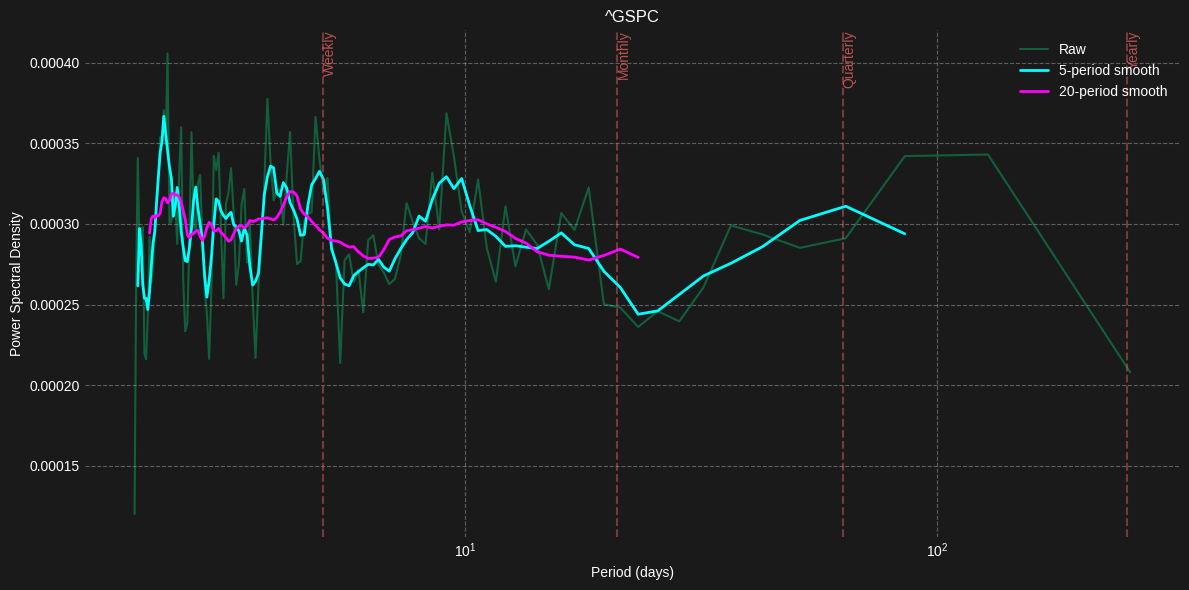

In [8]:
plot_spectral_analysis(cycles_results[0])

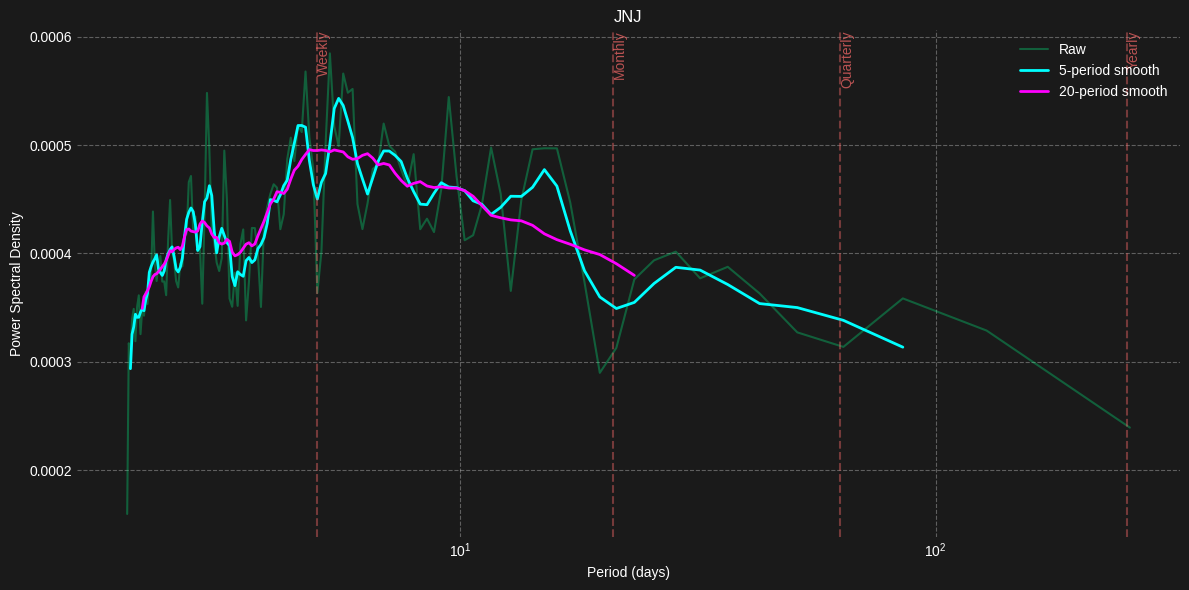

In [34]:
plot_spectral_analysis(cycles_results[16])

In [35]:
cycles_results[16]

{'symbol': 'JNJ',
 'frequencies': array([0.        , 0.00390625, 0.0078125 , 0.01171875, 0.015625  ,
        0.01953125, 0.0234375 , 0.02734375, 0.03125   , 0.03515625,
        0.0390625 , 0.04296875, 0.046875  , 0.05078125, 0.0546875 ,
        0.05859375, 0.0625    , 0.06640625, 0.0703125 , 0.07421875,
        0.078125  , 0.08203125, 0.0859375 , 0.08984375, 0.09375   ,
        0.09765625, 0.1015625 , 0.10546875, 0.109375  , 0.11328125,
        0.1171875 , 0.12109375, 0.125     , 0.12890625, 0.1328125 ,
        0.13671875, 0.140625  , 0.14453125, 0.1484375 , 0.15234375,
        0.15625   , 0.16015625, 0.1640625 , 0.16796875, 0.171875  ,
        0.17578125, 0.1796875 , 0.18359375, 0.1875    , 0.19140625,
        0.1953125 , 0.19921875, 0.203125  , 0.20703125, 0.2109375 ,
        0.21484375, 0.21875   , 0.22265625, 0.2265625 , 0.23046875,
        0.234375  , 0.23828125, 0.2421875 , 0.24609375, 0.25      ,
        0.25390625, 0.2578125 , 0.26171875, 0.265625  , 0.26953125,
        0.27343

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.signal import find_peaks
from tqdm import tqdm

def calculate_rolling_metrics(series, windows):
    """Calculate metrics over multiple rolling windows."""
    metrics = {}
    for window in windows:
        roll = series.rolling(window=window)
        metrics.update({
            f'mean_{window}d': roll.mean().iloc[-1],
            f'std_{window}d': roll.std().iloc[-1],
            f'skew_{window}d': roll.skew().iloc[-1],
            f'kurt_{window}d': roll.kurt().iloc[-1]
        })
    return metrics

def calculate_regime_metrics(returns, prices):
    """Calculate regime-based metrics."""
    # Detect volatility regimes using rolling variance
    vol = returns.rolling(window=21).std()
    high_vol_periods = vol > vol.mean() + vol.std()
    
    # Calculate metrics in different regimes
    metrics = {
        'high_vol_return': returns[high_vol_periods].mean(),
        'low_vol_return': returns[~high_vol_periods].mean(),
        'high_vol_freq': high_vol_periods.mean(),
        
        # Momentum metrics
        # 12-month momentum
        'price_momentum_12m': (prices / prices.shift(252) - 1).iloc[-1],
        # 6-month momentum
        'price_momentum_6m': (prices / prices.shift(126) - 1).iloc[-1],
        # 3-month momentum
        'price_momentum_3m': (prices / prices.shift(63) - 1).iloc[-1],
        # Acceleration: Change in 3-month momentum over previous 3 months
        'momentum_acceleration': ((prices / prices.shift(63) - 1) - 
                                (prices.shift(63) / prices.shift(126) - 1)).iloc[-1]
    }
    return metrics

def calculate_market_relative_metrics(symbol_data, market_data):
    """Calculate metrics relative to market benchmark."""
    # Align data
    combined = pd.merge(
        symbol_data['close'].pct_change().to_frame('symbol_return'),
        market_data['close'].pct_change().to_frame('market_return'),
        left_index=True, right_index=True,
        how='inner'
    )
    
    # Calculate rolling betas and correlations
    windows = [21, 63, 252]  # 1m, 3m, 1y
    metrics = {}
    
    for window in windows:
        roll = combined.rolling(window=window)
        cov = roll.cov().iloc[-1]
        beta = cov.loc['symbol_return', 'market_return'] / cov.loc['market_return', 'market_return']
        corr = roll.corr().iloc[-1].loc['symbol_return', 'market_return']
        
        metrics.update({
            f'beta_{window}d': beta,
            f'corr_{window}d': corr
        })
    
    # Calculate tracking error
    metrics['tracking_error'] = (
        (combined['symbol_return'] - combined['market_return']).std() * np.sqrt(252)
    )
    
    return metrics

def calculate_enhanced_metrics(df, market_benchmark=None):
    """
    Calculate enhanced financial metrics including multiple timeframes and market-relative metrics.
    
    Parameters:
    df: DataFrame with columns ['symbol', 'date', 'open', 'high', 'low', 'close', 'volume']
    market_benchmark: Optional DataFrame with market benchmark data
    """
    # Sort data
    df = df.sort_values(['symbol', 'date'])
    df.set_index('date', inplace=True)
    
    # Calculate returns
    df['return'] = df.groupby('symbol')['close'].pct_change()
    
    # Define analysis windows (in trading days)
    windows = {
        'short': [5, 21],      # 1w, 1m
        'medium': [63, 126],   # 3m, 6m
        'long': [252]          # 1y
    }
    
    metrics = []
    symbols = df['symbol'].unique()
    
    for symbol in tqdm(symbols, desc="Calculating enhanced metrics"):
        symbol_data = df[df['symbol'] == symbol]
        
        # Basic metrics over multiple timeframes
        symbol_metrics = {}
        for timeframe, timeframe_windows in windows.items():
            returns_metrics = calculate_rolling_metrics(
                symbol_data['return'], 
                timeframe_windows
            )
            volume_metrics = calculate_rolling_metrics(
                symbol_data['volume'], 
                timeframe_windows
            )
            symbol_metrics.update({
                f'returns_{k}': v for k, v in returns_metrics.items()
            })
            symbol_metrics.update({
                f'volume_{k}': v for k, v in volume_metrics.items()
            })
        
        # Add regime metrics
        regime_metrics = calculate_regime_metrics(
            symbol_data['return'],
            symbol_data['close']
        )
        symbol_metrics.update(regime_metrics)
        
        # Add market-relative metrics if benchmark provided
        if market_benchmark is not None:
            market_metrics = calculate_market_relative_metrics(
                symbol_data,
                market_benchmark
            )
            symbol_metrics.update(market_metrics)
        
        # Add quality metrics
        symbol_metrics.update({
            'data_quality_score': len(symbol_data) / 252,  # Years of data
            'missing_data_pct': symbol_data['close'].isna().mean() * 100,
            'symbol': symbol
        })
        
        metrics.append(symbol_metrics)
    
    return pd.DataFrame(metrics)

In [4]:
metrics = calculate_enhanced_metrics(filtered_df)

/tmp/ipykernel_1161/82820891.py:90: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['return'] = df.groupby('symbol')['close'].pct_change()
Calculating enhanced metrics: 100%|██████████| 3676/3676 [1:17:15<00:00,  1.26s/it]


In [5]:
metrics.shape

(3676, 50)

In [7]:
metrics.to_csv("financial_metrics_v2.csv")

In [10]:
metrics.columns

Index(['returns_mean_5d', 'returns_std_5d', 'returns_skew_5d',
       'returns_kurt_5d', 'returns_mean_21d', 'returns_std_21d',
       'returns_skew_21d', 'returns_kurt_21d', 'volume_mean_5d',
       'volume_std_5d', 'volume_skew_5d', 'volume_kurt_5d', 'volume_mean_21d',
       'volume_std_21d', 'volume_skew_21d', 'volume_kurt_21d',
       'returns_mean_63d', 'returns_std_63d', 'returns_skew_63d',
       'returns_kurt_63d', 'returns_mean_126d', 'returns_std_126d',
       'returns_skew_126d', 'returns_kurt_126d', 'volume_mean_63d',
       'volume_std_63d', 'volume_skew_63d', 'volume_kurt_63d',
       'volume_mean_126d', 'volume_std_126d', 'volume_skew_126d',
       'volume_kurt_126d', 'returns_mean_252d', 'returns_std_252d',
       'returns_skew_252d', 'returns_kurt_252d', 'volume_mean_252d',
       'volume_std_252d', 'volume_skew_252d', 'volume_kurt_252d',
       'high_vol_return', 'low_vol_return', 'high_vol_freq',
       'price_momentum_12m', 'price_momentum_6m', 'price_momentum_3m',